## Read and save data

In [1]:
-- Write to HDF5 using deepmind/torch-hdf5
require 'hdf5'

local myFile = hdf5.open('/tmp/sample_torch.h5', 'w')

myFile:write('random', torch.rand(5, 5))
myFile:write('tensor', torch.Tensor({{1,2,3,4,5},{6,7,8,9,10}}))

myFile:close()


In [4]:
-- Read from HDF5
require 'hdf5'

local myFile = hdf5.open('/tmp/sample_torch.h5', 'r')

local random = myFile:read('random'):all()
tensor = myFile:read('tensor'):all()

myFile:close()

print('Random:',random)
print('Tensor:',tensor)

Random:	 0.3720  0.5532  0.8844  0.7076  0.2407
 0.2454  0.3346  0.4899  0.4470  0.2805
 0.0007  0.0060  0.8522  0.2028  0.9565
 0.0670  0.3155  0.5306  0.3310  0.4846
 0.4578  0.4009  0.6855  0.1944  0.9049
[torch.DoubleTensor of size 5x5]

Tensor:	  1   2   3   4   5
  6   7   8   9  10
[torch.DoubleTensor of size 2x5]



In [2]:
print({{3}})

{
  1 : 
    {
      1 : 3
    }
}


In [14]:
-- Create tensors
a = torch.ones(1,5,2)
b = torch.zeros(1,1,4):float()
c = torch.Tensor(1,1):fill(4)

print(a,b,c)
print(a:transpose(2,3))
print(a[1][{{2,3}}])
print('A size:',a:size())

(1,.,.) = 
  1  1
  1  1
  1  1
  1  1
  1  1
[torch.DoubleTensor of size 1x5x2]

(1,.,.) = 
  0  0  0  0
[torch.FloatTensor of size 1x1x4]

 4
[torch.DoubleTensor of size 1x1]

(1,.,.) = 
  1  1  1  1  1
  1  1  1  1  1
[torch.DoubleTensor of size 1x2x5]

 1  1
 1  1
[torch.DoubleTensor of size 2x2]

A size:	 1
 5
 2
[torch.LongStorage of size 3]



## Define, train and test a network model
    1.- Load data
    2.- Define and train the network
    3.- Test network over new data


based on: 
https://github.com/soumith/cvpr2015/blob/master/Deep%20Learning%20with%20Torch.ipynb


### 1.- Load the data: cifar10

In [1]:

require 'paths'
if (not paths.filep("cifar10torchsmall.zip")) then
    os.execute('wget -c https://s3.amazonaws.com/torch7/data/cifar10torchsmall.zip')
    os.execute('unzip cifar10torchsmall.zip')
end
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}
{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


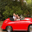

automobile	


In [2]:
print(trainset)
print(testset)
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])

In [3]:
-- Functions that we need to use the data on the train

-- Function to obtain pairs x,y
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);

trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.
testset.data = testset.data:double()

-- Define size function over trainset
function trainset:size() 
    return self.data:size(1) 
end

In [4]:
-- Rescale.  The easy way
print(trainset.data[{{1},{1},{1,5},{1,5}}])
trainset.data:div(255.0)
print(trainset.data[{{1},{1},{1,5},{1,5}}])

testset.data:div(255.0)



(1,1,.,.) = 
   59   43   50   68   98
   16    0   18   51   88
   25   16   49   83  110
   33   38   87  106  115
   50   59  102  127  124
[torch.DoubleTensor of size 1x1x5x5]



(1,1,.,.) = 
  0.2314  0.1686  0.1961  0.2667  0.3843
  0.0627  0.0000  0.0706  0.2000  0.3451
  0.0980  0.0627  0.1922  0.3255  0.4314
  0.1294  0.1490  0.3412  0.4157  0.4510
  0.1961  0.2314  0.4000  0.4980  0.4863
[torch.DoubleTensor of size 1x1x5x5]



### 2.- Define and train the network

In [5]:
require 'nn';

net = nn.Sequential()
net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

In [10]:
print('Net\n' .. net:__tostring());

Net
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> output]
  (1): nn.SpatialConvolution(3 -> 6, 5x5)
  (2): nn.ReLU
  (3): nn.SpatialMaxPooling(2x2, 2,2)
  (4): nn.SpatialConvolution(6 -> 16, 5x5)
  (5): nn.ReLU
  (6): nn.SpatialMaxPooling(2x2, 2,2)
  (7): nn.View(400)
  (8): nn.Linear(400 -> 120)
  (9): nn.ReLU
  (10): nn.Linear(120 -> 84)
  (11): nn.ReLU
  (12): nn.Linear(84 -> 10)
  (13): nn.LogSoftMax
}	


In [6]:
-- Criterions list


criterion = nn.ClassNLLCriterion()

In [7]:
-- Solver:

trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5 -- just do 5 epochs of training.

In [ ]:
input = trainset.data:cuda()
trainset.label = trainset.label:cuda()

for epoch = 1,5 do
    net:zeroGradParameters()
    output = net:forward(input)
    output = joiner:forward(output):float()
    gradOutputs = output:clone():zero()
    ctcCost = cpu_ctc(output, gradOutputs, labels, sizes)
    gradOutputs = gradOutputs:resize(nFrames, batchSize, nClasses):double()
    gradOutputs = splitter:forward(gradOutputs)    
    gradInputs = net:backward(input, gradOutputs)
    net:updateParameters(lrnRate)
end

# StochasticGradient: training	


### 3.- Train and test on GPU

In [8]:
require 'cunn';
net = net:cuda()
criterion = criterion:cuda()

trainset.data = trainset.data:cuda()
trainset.label = trainset.label:cuda()

trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5 -- just do 5 epochs of training.

trainer:train(trainset)


# StochasticGradient: training	


# current error = 2.3025504841089	


# current error = 2.2956860769272	


# current error = 2.1435543251276	


# current error = 1.9780875407934	


# current error = 1.8503770957351	
# StochasticGradient: you have reached the maximum number of iterations	
# training error = 1.8503770957351	


horse	


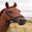

 0.0257
 0.0102
 0.1376
 0.0497
 0.1714
 0.0904
 0.1071
 0.3659
 0.0090
 0.0330
[torch.CudaTensor of size 10]



airplane	0.025673650205135	
automobile	0.010195383802056	
bird	0.13759727776051	
cat	0.049671798944473	
deer	0.17140376567841	
dog	0.090409204363823	
frog	0.10709649324417	
horse	0.36590525507927	
ship	0.0090133212506771	
truck	0.033033825457096	


In [9]:
-- Predict one case

testset.data = testset.data:cuda()
testset.label = testset.label:cuda()


print(classes[testset.label[100]])
itorch.image(testset.data[100])
predicted = net:forward(testset.data[100])
print(predicted:exp())

for i=1,predicted:size(1) do
    print(classes[i], predicted[i])
end

### Access to intermediate weigths and intermediate results


## Create a network using dp
http://dp.readthedocs.io/en/latest/

In [12]:
require 'dp';

In [15]:
-- Load dataset and preprocess it

local input_preprocess = {}
table.insert(input_preprocess, dp.Standardize())
-- table.insert(input_preprocess, dp.ZCA())
-- table.insert(input_preprocess, dp.GCN())
-- table.insert(input_preprocess, dp.LeCunLCN{progress=true})
    
ds = dp.Cifar10{data_path = '/tmp', input_preprocess = input_preprocess}

print(ds)

print(ds:featureSize())  -- inputSize

dp.Cifar10
{
  _data_folder : cifar-10-batches-t7
  _input_preprocess : 
    dp.Pipeline
    {
      _items : 
        {
          1 : 
            dp.Standardize
            {
       

       _std : FloatTensor - size: 1x3072
              _mean : FloatTensor - size: 1x3072
              _global_mean : false
              _global_std : false
              _std_eps : 0.0001
            }
        }
    }
  _download_url : http://torch7.s3-website-us-east-1.amazonaws.com/data/cifar10.t7.tgz
  _valid_set : 
    dp.DataSet
    {
      _inputs : 
        dp.ImageView
        {
          _warn : false
          _tensors : 
            {
              bchw : 
                {
                  torch.FloatTensor : FloatTensor - size: 10000x3x32x32
                }
            }
          _module_graph : table: 0x40e5cf10
          _gradOutputs : table: 0x40f7eb78
          _put : false
          _type : torch.FloatTensor
          _view : bchw
          _got : false
          _modules : 
            {
              bchw : 
                {
                  1 : nn.Identity
                  2 : table: 0x40e71f00
                }
            }
          _dim : 4
          

               torch.DoubleTensor : DoubleTensor - size: 10000
                }
            }
          _module_graph : table: 0x40e69a80
          _gradOutputs : table: 0x4109ef68
          _type : torch.DoubleTensor
          _view : b
          _classes : 
            {
              1 : 0
              2 : 1
              3 : 2
              4 : 3
              5 : 4
              6 : 5
              7 : 6
              8 : 7
              9 : 8
              10 : 9
            }
          _modules : 
            {
              b : 
                {
                  1 : nn.Identity
                  2 : table: 0x415a7bc8
                }
            }
          _dim : 1
          _input : DoubleTensor - size: 10000
        }
      _output_shape : b
    }
  _test_set : 
    dp.DataSet
    {
      _inputs : 
        dp.ImageView
        {
          _warn : false
          _tensors : 
            {
              bchw : 
                {
                  torch.FloatTensor : Floa

 {
                  1 : nn.Identity
                  2 : table: 0x407129a8
                }
            }
          _dim : 4
          _input : FloatTensor - size: 10000x3x32x32
        }
      _which_set : test
      _input_shape : bchw
      _targets : 
        dp.ClassView
        {
          _warn : false
          _tensors : 
            {
              b : 
                {
                  torch.DoubleTensor : DoubleTensor - size: 10000
                }
            }
          _module_graph : table: 0x404fc870
          _gradOutputs : table: 0x4190f660
          _type : torch.DoubleTensor
          _view : b
          _classes : 
            {
              1 : 0
              2 : 1
              3 : 2
              4 : 3
              5 : 4
              6 : 5
              7 : 6
              8 : 7
              9 : 8
              10 : 9
            }
          _modules : 
            {
              b : 
                {
                  1 : nn.Identity
             

                torch.FloatTensor : FloatTensor - size: 40000x3x32x32
                }
            }
          _module_graph : table: 0x40b627a8
          _gradOutputs : table: 0x40ec0a48
          _put : false
          _type : torch.FloatTensor
          _view : bchw
          _got : false
          _modules : 
            {
              bchw : 
                {
                  1 : nn.Identity
                  2 : table: 0x406ffc50
                }
            }
          _dim : 4
          _input : FloatTensor - size: 40000x3x32x32
        }
      _which_set : train
      _input_shape : bchw
      _targets : 
        dp.ClassView
        {
          _warn : false
          _tensors : 
            {
              b : 
                {
                  torch.DoubleTensor : DoubleTensor - size: 40000
                }
            }
          _module_graph : table: 0x40209c38
          _gradOutputs : table: 0x40224f18
          _type : torch.DoubleTensor
          _view : b
   

      _input : DoubleTensor - size: 40000
        }
      _output_shape : b
    }
  _scale : 
    {
      1 : 0
      2 : 1
    }
  args : 
    {
      1 : 0.2
      2 : cifar-10-batches-t7
      3 : /tmp
      5 : http://torch7.s3-website-us-east-1.amazonaws.com/data/cifar10.t7.tgz
      6 : true
      7 : 
        {
          1 : 
            dp.Standardize
            {
              _std : FloatTensor - size: 1x3072
              _mean : FloatTensor - size: 1x3072
              _global_mean : false
              _global_std : false
              _std_eps : 0.0001
            }
        }
      usage : +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Cifar10

> usage:
Cifar10{
    [valid_ratio = number]              -- proportion of training set to use for cross-validation.  [default = 0.2]
    [data_folder = string]              -- name of test_file  [default = cifar-10-batches-t7]
    [data_path = string]                -- path to data repository  [default = /t

In [16]:
print(ds:classes())

{
  1 : 0
  2 : 1
  3 : 2
  4 : 3
  5 : 4
  6 : 5
  7 : 6
  8 : 7
  9 : 8
  10 : 9
}


In [ ]:
-- Define the model
require 'nn';

net = nn.Sequential()
net:add(nn.Convert(ds:ioShapes(), 'bf')) -- to batchSize x nFeature (also type converts)

net:add(nn.SpatialConvolution(3, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax())                     -- converts the output to a log-probability. Useful for classification problems

In [ ]:
-- PENDING TO FINISH

-- Define AdaptiveDecay
opt.maxWait = 4
opt.decayFactor = 0.001
ad = dp.AdaptiveDecay{max_wait = opt.maxWait, decay_factor=opt.decayFactor}



-- Define the optimizer
opt.batchSize = 32
--opt.accUpdate = 
opt.learningRate = 0.1
opt.minLR = 0.00001
opt.momentum = 0
opt.maxOutNorm = 1

train = dp.Optimizer{
   acc_update = opt.accUpdate,
    
   loss = nn.ModuleCriterion(nn.ClassNLLCriterion(), nil, nn.Convert()),
    
   epoch_callback = function(model, report) -- called every epoch
      -- learning rate decay
      if report.epoch > 0 then
         if opt.lrDecay == 'adaptive' then
            opt.learningRate = opt.learningRate*ad.decay
            ad.decay = 1
         end
         opt.learningRate = math.max(opt.minLR, opt.learningRate)
         print("learningRate", opt.learningRate)
      end
   end,
        
   callback = function(model, report) -- called every batch
      if opt.accUpdate then
         model:accUpdateGradParameters(model.dpnn_input, model.output, opt.learningRate)
      else
         model:updateGradParameters(opt.momentum) -- affects gradParams
         model:updateParameters(opt.learningRate) -- affects params
      end
      model:maxParamNorm(opt.maxOutNorm) -- affects params
      model:zeroGradParameters() -- affects gradParams 
   end,
        
   feedback = dp.Confusion(),
        
   sampler = dp.ShuffleSampler{batch_size = opt.batchSize},
        
   progress = opt.progress
}


In [ ]:
-- Define the evaluators
valid = dp.Evaluator{
   feedback = dp.Confusion(),  
   sampler = dp.Sampler{batch_size = opt.batchSize}
}
test = dp.Evaluator{
   feedback = dp.Confusion(),
   sampler = dp.Sampler{batch_size = opt.batchSize}
}

In [1]:
require 'nn';

In [4]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 1 input image channel, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.SoftMax())                     -- converts the output to a log-probability. Useful for classification problems

print('Lenet5\n' .. net:__tostring());

Lenet5
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> output]
  (1): nn.SpatialConvolution(1 -> 6, 5x5)
  (2): nn.ReLU
  (3): nn.SpatialMaxPooling(2x2, 2,2)
  (4): nn.SpatialConvolution(6 -> 16, 5x5)
  (5): nn.ReLU
  (6): nn.SpatialMaxPooling(2x2, 2,2)
  (7): nn.View(400)
  (8): nn.Linear(400 -> 120)
  (9): nn.ReLU
  (10): nn.Linear(120 -> 84)
  (11): nn.ReLU
  (12): nn.Linear(84 -> 10)
  (13): nn.SoftMax
}	


In [7]:
input = torch.ones(1,32,32)
output = net:forward(input)
print(output)

net:zeroGradParameters()

gradInput = net:backward(input, torch.rand(10))
print(#gradInput)

 0.0973
 0.0901
 0.0976
 0.1062
 0.0981
 0.1032
 0.1102
 0.0920
 0.0948
 0.1104
[torch.DoubleTensor of size 10]



  1
 32
 32
[torch.LongStorage of size 3]

